# Model performance analysis

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [3]:
df = pd.read_csv('clean_data2.csv')
df.head()

,Unnamed: 0,url,selftext,title,subreddit,slftxt_ttl,target
0,0,https://www.reddit.com/r/malefashionadvice/com...,# Welcome to /r/MaleFashionAdvice!\n\n*MaleFas...,Welcome to /r/MaleFashionAdvice! Please click ...,malefashionadvice,# Welcome to /r/MaleFashionAdvice!\n\n*MaleFas...,1
1,1,https://www.reddit.com/r/malefashionadvice/com...,Welcome to the Daily Questions thread! Our dai...,Daily Questions - ASK AND ANSWER HERE!- July 10,malefashionadvice,Welcome to the Daily Questions thread! Our dai...,1
2,2,https://imgur.com/a/OFYDiC1,NaN,Linen: Embrace the Wrinkles,malefashionadvice,Linen: Embrace the Wrinkles,1
3,3,https://www.fastcompany.com/90371799/for-adida...,NaN,Adidas by Stella McCartney is making new cloth...,malefashionadvice,Adidas by Stella McCartney is making new cloth...,1
4,4,https://medium.com/@apparelandattire2018/profi...,NaN,Apparel &amp; Attire interview: Our very own /...,malefashionadvice,Apparel &amp; Attire interview: Our very own /...,1


In [4]:
df.drop(columns = 'Unnamed: 0', inplace=True)

In [6]:
# df['target'] = df['subreddit'].map(lambda x: 1 if x=='malefashionadvice' else 0)

In [5]:
# baseline accuracy

df['target'].value_counts(normalize=True)

0    1960
1    1875
Name: target, dtype: int64

In [6]:
# creating the dataframe for the model

df1 = df[['slftxt_ttl', 'target']]

I initiated lemmatizer and stemmatizer in order to see how these preprocessing tools affect my model. It turns out that the models perform better withouth these preprocessing tools

In [9]:
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

In [22]:
def msgs_to_words(msgs):

    msgs_text = BeautifulSoup(msgs).get_text()
    
    letters_only = re.sub("[^a-zA-Z]", " ", msgs)

    words = letters_only.lower().split()
    
#     lem_words = [lemmatizer.lemmatize(i) for i in words]
    
    stem_words = [p_stemmer.stem(i) for i in words]
    
    stops = set(stopwords.words('english'))
    
    meaningful_words = [w for w in stem_words if not w in stops]

    return(" ".join(meaningful_words))

### Splitting the dataset into training and validating set in order to evaluate our model on the validating set

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['slftxt_ttl'], df['target'], random_state=42)

For the NLP model the features have to be CountVectorized. The CountVectorizer transforms the features and in the case of this project creates the matrix containing all the words that the dataset contains and their respective number of counts in the document

In [8]:
cvec = CountVectorizer(analyzer='word',
                      max_features=1000)

In [9]:
X_train_cvec = cvec.fit_transform(X_train)

In [10]:
X_test_cvec = cvec.transform(X_test)

I decided to use three classification models and score them in order to compare.

- Logistic Regression provides better result compared to KNearest Neighbour and Multinomial Naive Bayes

In [11]:
mnb = MultinomialNB()
mnb.fit(X_train_cvec, y_train)
print(mnb.score(X_train_cvec, y_train))
print(mnb.score(X_test_cvec, y_test))

0.8856050069541029
0.881126173096976


In [12]:
lr = LogisticRegression()
lr.fit(X_train_cvec, y_train)
print(lr.score(X_train_cvec, y_train))
print(lr.score(X_test_cvec, y_test))

C:\Users\Rauan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9989568845618915
0.9822732012513035


In [13]:
knn = KNeighborsClassifier()
knn.fit(X_train_cvec, y_train)
print(knn.score(X_train_cvec, y_train))
print(knn.score(X_test_cvec, y_test))

0.9012517385257302
0.8633993743482794


In [14]:
preds = mnb.predict(X_test_cvec)
resids = y_test - preds

In [15]:
from sklearn.metrics import confusion_matrix

In [16]:
confusion_matrix(preds, y_test)

array([[447,  89],
       [ 25, 398]], dtype=int64)

I created confusion matrix for both Naive Bayes and Logistic Regression in order to interpret the results. The tables below clearly showcase Logisic Regression outperforming Naive Bayes model with zero False Positives as opposed to 89 posts. Although the False Negatives did not differ as much

In [17]:
pd.DataFrame(confusion_matrix(preds, y_test),
             columns=['pred female', 'pred male'], index=['actual female', 'actual male'])

,pred female,pred male
actual female,447,89
actual male,25,398


In [18]:
from sklearn.metrics import classification_report

In [19]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       472
           1       0.94      0.82      0.87       487

   micro avg       0.88      0.88      0.88       959
   macro avg       0.89      0.88      0.88       959
weighted avg       0.89      0.88      0.88       959



In [20]:
predictions = lr.predict(X_test_cvec)

In [21]:
pd.DataFrame(confusion_matrix(predictions, y_test),
             columns=['pred female', 'pred male'], index=['actual female', 'actual male'])

,pred female,pred male
actual female,455,0
actual male,17,487


In [22]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       472
           1       0.97      1.00      0.98       487

   micro avg       0.98      0.98      0.98       959
   macro avg       0.98      0.98      0.98       959
weighted avg       0.98      0.98      0.98       959



In [31]:
dense_matrix = X_train_cvec.todense()
feature_df = pd.DataFrame(dense_matrix, columns=cvec.get_feature_names())
feature_df.head(10)

,03,05,09,10,100,11,12,15,20,200,...,would,wrong,www,x200b,year,years,yet,you,your,yourself
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,2,0
2,0,0,0,0,2,0,0,0,0,0,...,2,0,0,0,2,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,3,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,3,0
6,0,0,0,2,1,0,0,0,0,0,...,1,0,70,0,1,1,0,7,5,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,3,1,0,0,0,0,11,4,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,5,2,0


In [33]:
import matplotlib.pyplot as plt

%matplotlib inline

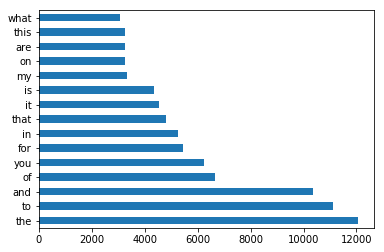

In [34]:
feature_df.sum().sort_values(ascending=False).head(15).plot(kind='barh');

From the graph above it can be seen the the most common words in the threads are basically stop words, so I decided to bring in the Pipeline and GridSearch in order to see how models performed with the various lists of Stop words. I tweaked the parameters of the CountVectorizer, and used Pipeline to employ Naive Bayes model and the Logistic regression model.

In [35]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [37]:
pipe = Pipeline([('cvec', CountVectorizer()),
                ('mnb', MultinomialNB())])

In [38]:
my_stop = list(ENGLISH_STOP_WORDS)
# my_stop.extend(['edu', 'com'])

pipe_params = {
    'cvec__max_features': [2000, 4000],
    'cvec__min_df': [3, 50],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': ['english', my_stop]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, verbose=1)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.9175938803894298


{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In [39]:
gs.score(X_train, y_train)

0.9516689847009736

In [40]:
gs.score(X_test, y_test)

0.9374348279457768

In [41]:
predics = gs.predict(X_test)

In [42]:
pd.DataFrame(confusion_matrix(predics, y_test),
            columns=['pred female', 'pred male'], index=['actual female', 'actual male'])

,pred female,pred male
actual female,468,56
actual male,4,431


In [43]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       472
           1       0.97      1.00      0.98       487

   micro avg       0.98      0.98      0.98       959
   macro avg       0.98      0.98      0.98       959
weighted avg       0.98      0.98      0.98       959



In [44]:
pipe2 = Pipeline([('cvec', CountVectorizer()),
                ('lr', LogisticRegression())])

In [45]:
my_stop = list(ENGLISH_STOP_WORDS)

params = {
    'cvec__max_features': [2000, 4000],
    'cvec__min_df': [3, 30],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': ['english', None, my_stop]
}
gs2 = GridSearchCV(pipe2, param_grid=params, cv=3, verbose=1)
gs2.fit(X_train, y_train)
print(gs2.best_score_)
gs2.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Rauan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  2.7min finished


0.9787899860917941


{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 30,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None}

In [46]:
gs2.score(X_train, y_train)

1.0

In [47]:
gs2.score(X_test, y_test)

0.9916579770594369

In [48]:
pred = gs2.predict(X_test)

In [49]:
pd.DataFrame(confusion_matrix(pred, y_test),
            columns=['pred female', 'pred male'], index=['actual female', 'actual male'])

,pred female,pred male
actual female,464,0
actual male,8,487


In [50]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       472
           1       0.98      1.00      0.99       487

   micro avg       0.99      0.99      0.99       959
   macro avg       0.99      0.99      0.99       959
weighted avg       0.99      0.99      0.99       959



It can be observed above that the Logist Regression outperforms the Naiev Bayes and also requires less features for the model, in essence requiring less time to run

To check out the project and the EDA click on this [link](./Project_3.ipynb)